# Vision Transformers vs. CNN on CIFAR-10

## Training for VIT

In [1]:
# Install required package
!pip install timm --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and preprocess CIFAR-10

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [5]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## Train ViT

In [6]:
# Load ViT Tiny
vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)
vit = vit.to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-4)

# Train with early stopping (patience=2, max 20 epochs)
epochs = 20
best_acc = 0.0
patience = 2
wait = 0
best_model = copy.deepcopy(vit.state_dict())
train_accs, test_accs = [], []
train_losses, test_losses = [], []

for epoch in range(epochs):
    vit.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        acc = 100 * correct / total
        loop.set_postfix(loss=loss.item(), acc=acc)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(avg_train_loss)

    test_acc, avg_test_loss = evaluate(vit, test_loader, device,criterion)
    test_accs.append(test_acc)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%, "
          f"Train Loss={avg_train_loss:.4f}, Test Loss={avg_test_loss:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(vit.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

# 6. Save Best Model
torch.save(best_model, "vit_cifar10.pth")
print(f"Best Test Accuracy: {best_acc:.2f}%")


Epoch 1: Train Acc=92.16%, Test Acc=94.87%, Train Loss=0.2317, Test Loss=0.1484


Epoch 2: Train Acc=97.06%, Test Acc=94.69%, Train Loss=0.0866, Test Loss=0.1576


Epoch 3: Train Acc=97.86%, Test Acc=95.64%, Train Loss=0.0622, Test Loss=0.1435


Epoch 4: Train Acc=98.36%, Test Acc=94.72%, Train Loss=0.0463, Test Loss=0.1793


Epoch 5: Train Acc=98.49%, Test Acc=95.35%, Train Loss=0.0460, Test Loss=0.1615
Early stopping triggered at epoch 5.
Best Test Accuracy: 95.64%


## Plot and Compare

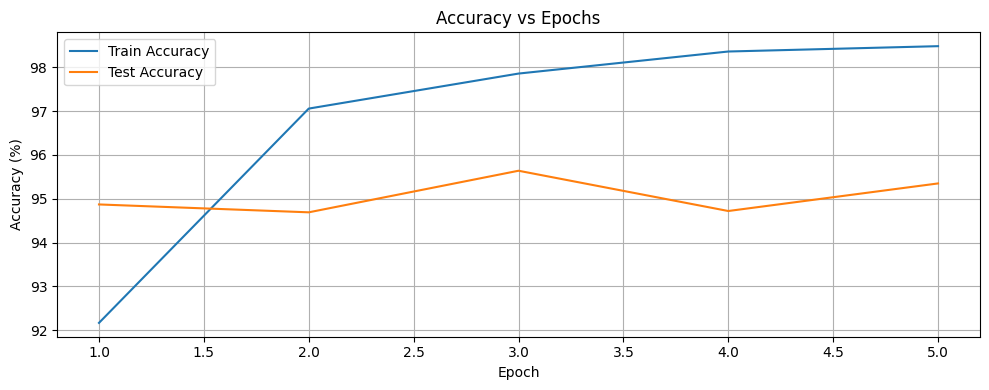

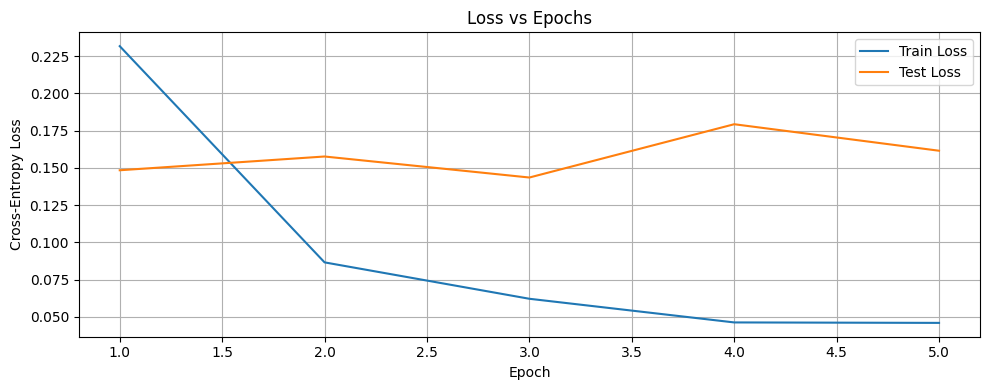

Saved: accuracy_plot.png, loss_plot.png, training_stats.pkl


In [11]:
import matplotlib.pyplot as plt
import pickle

# Define epochs based on available training data
epochs = list(range(1, len(train_accs) + 1))

# 1. Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
acc_path = "accuracy_plot.png"
plt.savefig(acc_path)
plt.show()  # Show in notebook
plt.close()

# 2. Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_path = "loss_plot.png"
plt.savefig(loss_path)
plt.show()  # Show in notebook
plt.close()

# 3. Save training statistics to dictionary
training_stats = {
    "epochs": epochs,
    "train_accs": train_accs,
    "test_accs": test_accs,
    "train_losses": train_losses,
    "test_losses": test_losses
}

stats_path = "training_stats.pkl"
with open(stats_path, "wb") as f:
    pickle.dump(training_stats, f)

print(f"Saved: {acc_path}, {loss_path}, {stats_path}")
